In [ ]:
!pip install torch-geometric


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import APPNP
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dropout_adj


In [ ]:
# --- Custom transform for L1 normalization (Fix: replace L2 with L1 normalization) ---
class NormalizeFeaturesL1(object):
    def __call__(self, data):
        data.x = data.x / data.x.sum(dim=1, keepdim=True).clamp(min=1e-6)
        return data

In [ ]:
# Load CORA dataset
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to('cuda' if torch.cuda.is_available() else 'cpu')
print("Edge index shape:", data.edge_index.shape)
print("Edge weights (if normalized):", hasattr(data, 'edge_weight'))

Edge index shape: torch.Size([2, 10556])
Edge weights (if normalized): True


In [ ]:
#  --- APPNP Model (Fix: Glorot init + adjacency dropout in forward) ---
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=10, alpha=0.1):
        super(Net, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
        self.prop = APPNP(K=K, alpha=alpha)

        # Fix: Glorot initialization (matches paper)
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        # Fix: Resample adjacency dropout for each forward pass (matches paper)
        if self.training:
            edge_index, _ = dropout_adj(edge_index, p=0.5)
        return self.prop(x, edge_index)

In [ ]:
model = Net(dataset.num_features, 64, dataset.num_classes).to(data.x.device)
# Fix: Remove weight_decay (paper uses L2 only on first layer)
optimizer = torch.optim.Adam([
    {'params': model.lin1.parameters(), 'weight_decay': 0.005},  # L2 on first layer (paper Sec 6)
    {'params': model.lin2.parameters(), 'weight_decay': 0.0}     # No L2 on second layer
], lr=0.01)

In [ ]:

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Dropout resampled inside forward()
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    logits = model(data.x, data.edge_index)  # No dropout during eval
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].argmax(dim=1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [ ]:
import time

In [ ]:
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()


In [ ]:
import os
import matplotlib.pyplot as plt
import csv

log_file = "appnp_training_log.csv"
log_fields = ["epoch", "loss", "train_acc", "val_acc", "test_acc", "epoch_time","gpu_mem"]

# Prepare CSV logging
with open(log_file, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=log_fields)
    writer.writeheader()

# Metric tracking for plotting
history = {"epoch": [], "loss": [], "train_acc": [], "val_acc": [], "test_acc": [], "epoch_time": [], "gpu_mem" : []}


best_val_acc = 0
patience = 100
patience_counter = 0
gpu_memory_usage = []
for epoch in range(1, 1001):
    start_time = time.time()
    loss = train()
    train_acc, val_acc, test_acc = test()
    epoch_time = time.time() - start_time
    if torch.cuda.is_available():
        peak_mem = torch.cuda.max_memory_allocated() / 1024**2
    else:
        peak_mem = 0
    gpu_memory_usage.append(peak_mem)

    # Save metrics to history
    history["epoch"].append(epoch)
    history["loss"].append(loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["test_acc"].append(test_acc)
    history["epoch_time"].append(epoch_time)
    history["gpu_mem"].append(peak_mem)

    # Log to CSV
    with open(log_file, "a", newline="") as f:
      writer = csv.DictWriter(f, fieldnames=log_fields)
      writer.writerow({
          "epoch": epoch,
          "loss": loss,
          "train_acc": train_acc,
          "val_acc": val_acc,
          "test_acc": test_acc,
          "epoch_time": epoch_time,
          "gpu_mem": peak_mem
      })


    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


Epoch 001, Loss: 0.6562, Train: 0.9714, Val: 0.7880, Test: 0.8000
Epoch 002, Loss: 0.6266, Train: 0.9643, Val: 0.7800, Test: 0.7920
Epoch 003, Loss: 0.6473, Train: 0.9714, Val: 0.7900, Test: 0.7980
Epoch 004, Loss: 0.6467, Train: 0.9643, Val: 0.7860, Test: 0.8090
Epoch 005, Loss: 0.6325, Train: 0.9786, Val: 0.7820, Test: 0.8170
Epoch 006, Loss: 0.5977, Train: 0.9857, Val: 0.7860, Test: 0.8260
Epoch 007, Loss: 0.6541, Train: 0.9714, Val: 0.7920, Test: 0.8180
Epoch 008, Loss: 0.6148, Train: 0.9643, Val: 0.7900, Test: 0.8180
Epoch 009, Loss: 0.5862, Train: 0.9643, Val: 0.8000, Test: 0.8210
Epoch 010, Loss: 0.6397, Train: 0.9571, Val: 0.8020, Test: 0.8210
Epoch 011, Loss: 0.6014, Train: 0.9714, Val: 0.8080, Test: 0.8240
Epoch 012, Loss: 0.7149, Train: 0.9714, Val: 0.8000, Test: 0.8140
Epoch 013, Loss: 0.5817, Train: 0.9714, Val: 0.7920, Test: 0.8080
Epoch 014, Loss: 0.6668, Train: 0.9714, Val: 0.7860, Test: 0.8020
Epoch 015, Loss: 0.6041, Train: 0.9714, Val: 0.7740, Test: 0.8050
Epoch 016,

In [ ]:
gpu_mem = torch.cuda.max_memory_allocated() / 1024**2  # MB
print(f"Peak GPU memory usage: {gpu_mem:.2f} MB")


Peak GPU memory usage: 0.00 MB


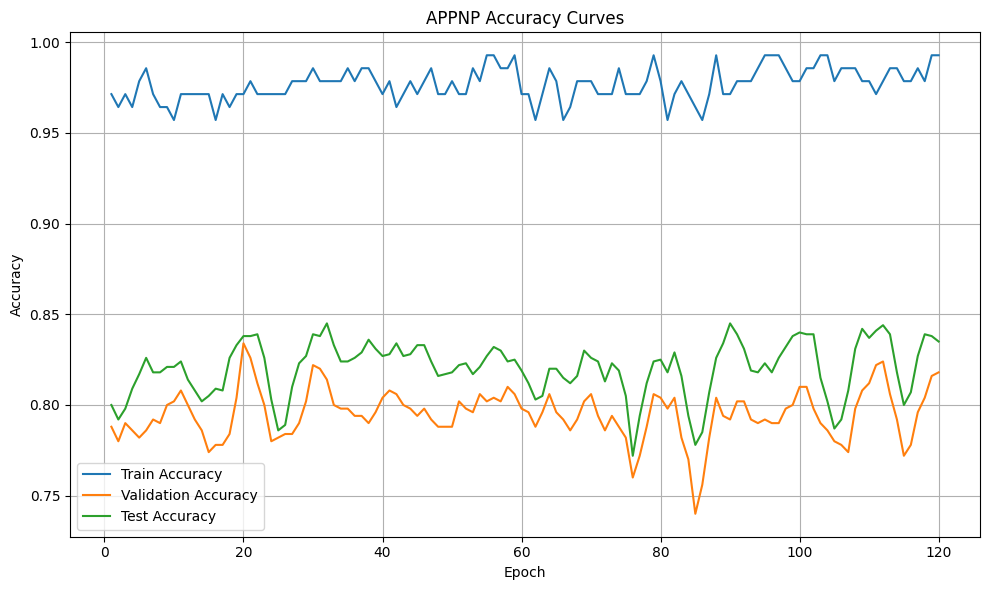

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.plot(history["epoch"], history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("APPNP Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("appnp_accuracy_plot.png")
plt.show()


In [ ]:
print("\n=== Final Benchmark Summary ===")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Avg Epoch Time: {sum(history['epoch_time']) / len(history['epoch_time']):.4f} sec")
print(f"Peak GPU Memory: {max(history['gpu_mem']):.2f} MB")



=== Final Benchmark Summary ===
Best Validation Accuracy: 0.8340
Avg Epoch Time: 0.0854 sec
Peak GPU Memory: 0.00 MB
